# Использование физически информированной нейронной сети (PINN) для моделирования поперечных колебаний идеальной струны в двух взаимно перпендикулярных направлениях в нелинейном приближении

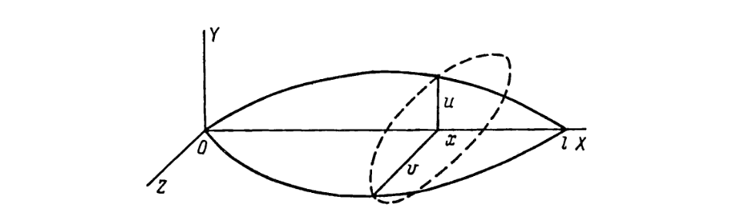

##Введение

В последние годы физически информированные нейронные сети $(PINN)$ всё чаще применяются к решению дифференциальных уравнений в частных производных ($PDE$). Отдельный интерес представляет решение [задач](https://www.researchgate.net/publication/383078380_Physics-informed_neural_network_for_nonlinear_dynamics_of_self-trapped_necklace_beams) в нелинейном приближении, когда в уравнении фигурируют комбинации произведений и степеней функции и её частных производных высоких порядков.

Ранее $PINN$ уже применялись к решению волнового уравнения в линейном приближении в [одномерном](https://github.com/okada39/pinn_wave/tree/master) и [многомерном](https://arxiv.org/pdf/2006.11894) случаях. В случае описания динамики струны такой подход позволяет ограничить исследование вычислением вторых производных по координатам и времени, из физических параметров задачи используя лишь линейную плотность и натяжение. Такая постановка позволяет получить аналитическое решение.

Как [показано](https://mtt.ipmnet.ru/files/1993/1993-4/mtt1993_n4_p87-92.pdf) Л. Д. Акуленко и С. В. Нестеровым, описание динамики струны с жёстко закреплёнными концами в нелинейном приближении при колебаниях вдоль двух взаимно ортогональных осей $u$ и $v$ приводит к возникновению связи между величинами $u$ и $v$. Авторами предложено одномодное аналитическое решение с использованием ряда приближений.

Мы предлагаем решение системы дифференциальных уравнений в частных производных, описывающей динамику движения струны с закреплёнными концами для заданных начальных условий, с использованием физически информированной нейронной сети $PINN$. В работе использованы современные [подходы](https://arxiv.org/pdf/2308.08468) к повышению качества обучения $PINN$: обезразмеривание, взвешивание потерь от разных элементов системы, экспоненциальное взвешивание потерь от временных сегментов на внутренних точках, представление входных данных с использованием случайных Фурье-признаков и т. д.

В результате выполнения работы обучена модель $StringNet$, для передаваемых в неё точек предсказывающая значения отклонений $(u, v)$ от положения равновесия. Получена 3D-визуализация колебаний струны во времени. Решение показывает хорошее соответствие начальным и граничным условиям, обладает гладкостью.

##Постановка задачи

Рассмотрим систему уравнений движения струны в двух поперечных направлениях $u(x,t)$, $v(x,t)$ на отрезке $x \in [0, L]$, $t≥0$. Как параметры струны заданы модуль Юнга $E$, площадь сечения струны $S$, натяжение в положении равновесия $T$ и параметр $N = ES - T$.

Используется система дифференциальных уравнений в частных производных, описывающая колебания струны с жёстко закреплёнными концами, полученная в первом нелинейном приближении. Система указывает на то, что использования членов более высокого порядка, чем линейный, приводит к возникновению связи между колебаниями в двух ортогональных направлениях:

$$\rho u_{tt} = (T + \tfrac12 N (u_x^2 + v_x^2)) u_{xx} + N (u_x u_{xx} + v_x v_{xx}) u_x$$

$$\rho v_{tt} = (T + \tfrac12 N (u_x^2 + v_x^2)) v_{xx} + N (u_x u_{xx} + v_x v_{xx}) v_x$$

Граничные условия, соответствующие жёсткому закреплению обоих концов:

$$u(0,t)=u(L,t)=0,$$
$$v(0,t)=v(L,t)=0$$

Начальные условия для примера выберем следующего вида:

$$u(x,0)=A\sin(\frac{2\pi x}{L}),$$
$$v(x,0)=4A\frac{x}{L}(1-\frac{x}{L}),$$

где $A$ — амплитуда колебаний, много меньшая $L$. Начальные скорости взяты нулевыми:

$$u_t(x, 0)=0,$$
$$v_t(x, 0)=0$$


##Решение

###Обезразмеривание

Введём безразмерные переменные:

$$x'=\frac{x}{L},\quad t'=\frac{ct}{L},\quad u'=\frac{u}{A},\quad v'=\frac{v}{A},\quad c=\sqrt{\frac{T}{\rho}}$$

После приведения получаем:

$$u_{tt} = \Bigl(1 + \tfrac12\beta (u_x^2+v_x^2)\Bigr) u_{xx} + \beta (u_x u_{xx} + v_x v_{xx}) u_x,$$

$$v_{tt} = \Bigl(1 + \tfrac12\beta (u_x^2+v_x^2)\Bigr) v_{xx} + \beta (u_x u_{xx} + v_x v_{xx}) v_x,$$

где параметр $\beta=\dfrac{N}{T}\dfrac{A^2}{L^2}$ обычно полагается много меньшим $1$.

Начальные условия в безразмерной форме:

$$u(x,0)=\sin(2\pi x),\quad v(x,0)=4x(1-x),\quad u_t(x,0)=v_t(x,0)=0$$

Краевые условия:

$$u(0,t)=u(1,t)=0, \quad v(0,t)=v(1,t)=0$$

###Сбор данных

Импортируем основные библиотеки для написания нейросетей и анализа данных.

In [1]:
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, Subset
from tqdm.notebook import trange

import matplotlib.pyplot as plt
import matplotlib.animation as animation
from mpl_toolkits.mplot3d import Axes3D

import imageio
import os
import shutil

from itertools import cycle


torch.manual_seed(42)
np.random.seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:", device)

device: cuda


Зададим примерные физичные значения параметров струны. Начальные функции $u(x,0)$, $v(x,0)$ и начальные скорости $g_u$, $g_v$ возьмём в соответствии с примером.

In [2]:
A = 0.1
L = 1.0
t_max = 1.0
c = 1.0

rho = 1.0
T = 1.0
N_param = 0.5
beta = (N_param / T) * (A**2 / L**2)

t_scale = L / c
u_scale = A

###Формирование обучающей выборки

Зададим параметры обучающей выборки. Внутренние точки будем называть $collocation$, граничные условия $border\ conditions$, начальные условия $initial\ conditions$.

In [3]:
n_collocation = 15000
n_bc = 300
n_ic = 300
batch_size = 64

Генерируем внутренние точки из равномерного распределения.

In [4]:
x_coll = torch.rand(n_collocation, 1, device=device)
t_coll = torch.rand(n_collocation, 1, device=device) * t_max

Сгенерируем точки для начальных условий.

In [5]:
x_ic = torch.linspace(0, 1, n_ic, device=device).unsqueeze(1)
t_ic = torch.zeros_like(x_ic)

u_ic = torch.sin(2 * np.pi * x_ic)
v_ic = 4.0 * x_ic * (1.0 - x_ic)

Составим тензоры для граничных условий. Значения $x$ всегда слева $0$, а справа $1$. Время получаемся из равномерного распределения в диапазоне от $0$ до $t_{max}$.

In [6]:
x_b0 = torch.zeros(n_bc // 2, 1, device=device)
x_b1 = torch.ones(n_bc - n_bc // 2, 1, device=device)

t_bc = torch.rand(n_bc, 1, device=device) * t_max
x_bc = torch.cat([x_b0, x_b1], dim=0)

Построим графики $u(x, 0)$ и $v(x, 0)$.

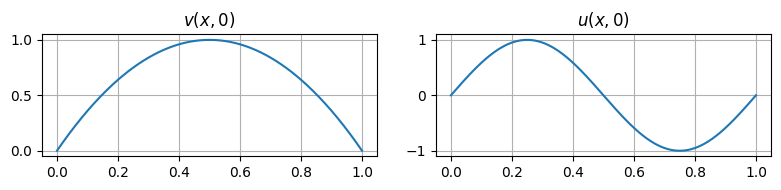

In [7]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 2))

data_titles = [
    (v_ic, '$v(x, 0)$'),
    (u_ic, '$u(x, 0)$')
]

for ax, (data, title) in zip(axes.flatten(), data_titles):
    ax.plot(x_ic.cpu(), data.cpu())
    ax.set_title(title)
    ax.grid(True)

plt.tight_layout()
plt.show()

###Разбиение внутренних точек по M временным сегментам

Для данных будем использовать не один загрузчик данных, а несколько последовательных, соответствующих разным моментам времени. Такой подход позволяет задавать больший вес для потерь в начале движения.

Разделяем исходный массив $[x_{coll}, t_{coll}]$ на $M$ (около $10$) сегментов по $t'$ и формируем для каждого сегмента загрузчик данных. Это позволит рассчитывать потери $L_r^i$ отдельно по каждому $i$-му сегменту, а затем складывать с учётом кумулятивно убывающего веса:

$$\mathcal{L}_r(\mathbf{\theta}) = \frac{1}{M} \sum_{i=1}^M w_i \mathcal L_r^i(\mathbf{\theta}),$$
$$w_i = \exp\left(- \epsilon \sum_{k=1}^{i-1}  \mathcal{L}_r^k( \mathbf{\theta})\right),$$

где $i$ изменяется от $2$ до $M$. $\epsilon$ — гиперпараметр, который можно принять равным $1$.

In [8]:
def make_segmented_coll_loaders(x_coll_arr, t_coll_arr, M=8, batch_size=64):
    t_s = (t_coll_arr / t_scale)
    seg_idx = np.minimum(( (t_s.cpu().numpy().reshape(-1) * M).astype(int)), M-1)
    seg_loaders = []
    for i in range(M):
        mask = (seg_idx == i)
        xs = x_coll_arr[mask]
        ts = t_coll_arr[mask]
        if xs.shape[0] == 0:
            xs = x_coll_arr[:batch_size]
            ts = t_coll_arr[:batch_size]
        ds = TensorDataset(xs, ts)
        loader = DataLoader(ds, batch_size=batch_size, shuffle=True)
        seg_loaders.append(loader)
    return seg_loaders

M = 8
seg_coll_loaders = make_segmented_coll_loaders(x_coll, t_coll, M=M, batch_size=batch_size)

Зададим начальные значения.

In [9]:
w_i = torch.ones(M, dtype=torch.float32, device=device)
epsilon = 1.0

Функция дли обновления временных весов $w_i$ для потерь на сегментах.


In [10]:
def update_temporal_weights(w, Lr_list, epsilon=1.0):
    Lr = torch.tensor(Lr_list, dtype=torch.float32, device=device)
    M = len(w)
    cum = torch.zeros(1, dtype=w.dtype, device=w.device)
    new_w = w.clone()
    new_w[0] = 1.0
    for i in range(1, M):
        cum += float(Lr_list[i-1])
        new_w[i] = torch.exp(-epsilon * cum)
    return new_w

###Масштабирование потерь

Введём глобальные веса $\lambda$ для масштабирования потерь от начальных и граничных условий и потерь на внутренних точках:

$$\hat{\lambda}_{ic} =  \frac{  \|\nabla_{\theta}  \mathcal{L}_{ic}(\theta)\| +  \|\nabla_{\theta}  \mathcal{L}_{bc}(\theta)\| +  \|\nabla_{\theta}  \mathcal{L}_{r}(\theta)\|   } {\|\nabla_{\theta}  \mathcal{L}_{ic}(\theta)\|},$$
$$\hat{\lambda}_{bc} = \frac{  \|\nabla_{\theta}  \mathcal{L}_{ic}(\theta)\| +  \|\nabla_{\theta}  \mathcal{L}_{bc}(\theta)\| +  \|\nabla_{\theta}  \mathcal{L}_{r}(\theta)\|   } {\|\nabla_{\theta}  \mathcal{L}_{bc}(\theta)\|},$$
$$\hat{\lambda}_{r} =  \frac{  \|\nabla_{\theta}  \mathcal{L}_{ic}(\theta)\| +  \|\nabla_{\theta}  \mathcal{L}_{bc}(\theta)\| +  \|\nabla_{\theta}  \mathcal{L}_{r}(\theta)\|   } {\|\nabla_{\theta}  \mathcal{L}_{r}(\theta)\|}$$

В противном случае значения потерь могут различаться на несколько порядков. Реализуем функцию, вычисляющую градиент потерь по параметрам и $L2$-норму градиента.

In [11]:
def grad_norm_for_loss(loss, params):
    grads = torch.autograd.grad(loss, params, retain_graph=True, create_graph=False, allow_unused=True)
    sq = 0.0
    for g in grads:
        if g is None:
            continue
        sq = sq + torch.sum(g.detach()**2)
    return torch.sqrt(sq).item()

Параметры $\lambda$ будем обновлять как взвешенное скользящее среднее:

$$\mathbf{\lambda}_{\text{new}} =  \alpha  \mathbf{\lambda}_{\text{old}}  + (1 - \alpha) \hat{\mathbf{\lambda}}_{\text{new}}$$

Установим начальные $\lambda_{ic}$, $\lambda_{bc}$, $\lambda_{r}$ $= 1.0$. Зададим период обновления глобальных весов $f$ и параметр $\alpha$.

In [12]:
lambda_ic = 1.0
lambda_bc = 1.0
lambda_r = 1.0
f = 1000
alpha = 0.9

###Загрузчики

Инициализируем датасеты на основе синтетических данных для начальных и граничных условий.

In [13]:
bc_ds = TensorDataset(x_bc, t_bc)
ic_ds = TensorDataset(x_ic, t_ic, u_ic, v_ic)

Создаём загрузчики данных для датасетов.

In [14]:
bc_loader = DataLoader(bc_ds, batch_size=batch_size, shuffle=True)
ic_loader = DataLoader(ic_ds, batch_size=batch_size, shuffle=True)

Преобразуем загрузчики в зацикленные итераторы.

In [15]:
ic_iter = cycle(ic_loader)
bc_iter = cycle(bc_loader)
coll_iters = [cycle(loader) for loader in seg_coll_loaders]

###Метод случайных Фурье-признаков

Используем `Random Fourier Feature (RFF) embedding`. Для вектора входов $z = [x', t']$ строим:

$$gamma(z) = [\cos(Bz), \sin(Bz)],$$

где значения $B$ взяты из нормального распределения, $B \sim  \mathcal{N} (0, \sigma^2)$. Стоит использовать более $100$ различных значений.

In [16]:
class RFFEmbed(nn.Module):
    def __init__(self, in_dim=2, n_features=256, sigma=5.0, device='cpu', dtype=torch.float32):
        super().__init__()
        self.in_dim = in_dim
        self.nf = n_features
        self.sigma = sigma
        B = torch.randn(n_features, in_dim, dtype=dtype) * sigma
        self.register_buffer('B', B.to(device))

    def forward(self, x):
        proj = x @ self.B.t()
        cos = torch.cos(proj)
        sin = torch.sin(proj)
        return torch.cat([cos, sin], dim=-1)

###Моделирование

Реализуем модель с $4$ скрытыми слоями и функцией активации `Tanh()`. Использование `RFF` опционально, так как значительно усложняет процесс обучения модели с точки зрения вычислений, хотя и повышает точность результата на порядки.

In [17]:
class StringNet(nn.Module):
    def __init__(
            self,
            rff_nf=32,
            hidden_sizes=(60,60,60,60),
            sigma=5.0,
            device='cpu',
            activation=nn.Tanh(),
            dtype=torch.float32,
            use_rff=False
        ):
        super().__init__()
        self.use_rff = use_rff
        in_dim = 2

        if self.use_rff:
            self.rff = RFFEmbed(in_dim=2, n_features=rff_nf, sigma=sigma, device=device, dtype=dtype)
            in_dim *= rff_nf

        layers = []
        for h in hidden_sizes:
            layers.append(nn.Linear(in_dim, h))
            layers.append(activation)
            in_dim = h
        layers.append(nn.Linear(in_dim, 2))

        self.model = nn.Sequential(*layers)
        self.init_weights()

    def init_weights(self):
        for m in self.model:
            if isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
                nn.init.zeros_(m.bias)

    def forward(self, x, t):
        xt = torch.cat([x, t], dim=1)
        if self.use_rff:
            xt = self.rff(xt)
        uv = self.model(xt)
        return uv

###Вычисление невязок

Вычисляем производные $\partial_{x'}$ и $\partial_{t'}$ через $autograd$ (работаем с $x'$, $t'$). После этого считаем невязки ($residuals$).

In [18]:
def grad(u, var):
    return torch.autograd.grad(u, var, grad_outputs=torch.ones_like(u), create_graph=True, retain_graph=True)[0]

def second_grad(u, var):
    first = grad(u, var)
    return grad(first, var)

def pde_residuals_scaled(model, x, t, beta_param):
    x_var = x.clone().detach().requires_grad_(True)
    t_var = t.clone().detach().requires_grad_(True)

    uv = model(x_var, t_var)
    u = uv[:, 0:1]
    v = uv[:, 1:2]

    u_tt = second_grad(u, t_var)
    v_tt = second_grad(v, t_var)

    u_x = grad(u, x_var)
    v_x = grad(v, x_var)
    u_xx = second_grad(u, x_var)
    v_xx = second_grad(v, x_var)

    S = u_x**2 + v_x**2
    common = 1.0 + 0.5 * beta_param * S
    coupling = beta_param * (u_x * u_xx + v_x * v_xx)

    res_u = u_tt - (common * u_xx + coupling * u_x)
    res_v = v_tt - (common * v_xx + coupling * v_x)

    return res_u, res_v

###Обучение нейросети

Инициализируем модель. В данном примере не используем `RFF`.

In [19]:
model = StringNet(device=device, use_rff=False).to(device)
print(model)

StringNet(
  (model): Sequential(
    (0): Linear(in_features=2, out_features=60, bias=True)
    (1): Tanh()
    (2): Linear(in_features=60, out_features=60, bias=True)
    (3): Tanh()
    (4): Linear(in_features=60, out_features=60, bias=True)
    (5): Tanh()
    (6): Linear(in_features=60, out_features=60, bias=True)
    (7): Tanh()
    (8): Linear(in_features=60, out_features=2, bias=True)
  )
)


Потери считаем по `MSE`, оптимизатором выбираем `Adam`. Опыт показывает, что для обучения лучше всего подходит $lr=10^{-3}$. На случай принудительного ручного уменьшения $lr$ в $10$ раз добавляем `scheduler()`.

In [20]:
optimizer = optim.Adam(model.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.1)
mse = nn.MSELoss()

Объявим функции для вычисления потерь на батчах.

In [21]:
def loss_ic_batch(model, xb_ic, tb_ic, uic, vic, guic=None, gvic=None):
    xb_ic = xb_ic.to(device)
    tb_ic = tb_ic.to(device)
    uic = uic.to(device)
    vic = vic.to(device)

    xb_ic = xb_ic.requires_grad_(True)
    tb_ic = tb_ic.requires_grad_(True)

    uv_pred = model(xb_ic, tb_ic)
    u_s_pred = uv_pred[:, 0:1]
    v_s_pred = uv_pred[:, 1:2]

    u_t_s = torch.autograd.grad(u_s_pred, tb_ic, torch.ones_like(u_s_pred), create_graph=True)[0]
    v_t_s = torch.autograd.grad(v_s_pred, tb_ic, torch.ones_like(v_s_pred), create_graph=True)[0]

    loss = mse(u_s_pred, uic) + mse(v_s_pred, vic)
    loss = loss + mse(u_t_s, torch.zeros_like(u_t_s)) + mse(v_t_s, torch.zeros_like(v_t_s))
    return loss

def loss_bc_batch(model, xb_bc, tb_bc):
    xb_bc = xb_bc.to(device)
    tb_bc = tb_bc.to(device)

    uv_pred = model(xb_bc, tb_bc)
    u_s_pred = uv_pred[:, 0:1]
    v_s_pred = uv_pred[:, 1:2]

    ubc = torch.zeros_like(u_s_pred)
    vbc = torch.zeros_like(v_s_pred)

    loss = mse(u_s_pred, ubc.to(device)) + mse(v_s_pred, vbc.to(device))
    return loss

def loss_r_batch(model, xb_r, tb_r, beta_param):
    xb_r = xb_r.to(device)
    tb_r = tb_r.to(device)

    res_u, res_v = pde_residuals_scaled(model, xb_r, tb_r, beta_param)
    return torch.mean(res_u**2 + res_v**2)

###Цикл обучения

Функционал для изменения скорости обучения по необходимости.

In [38]:
scheduler.step()

Обучим нейросеть с использование описанных выше техник. Сохраняем потери в историю. При использовании `T4 GPU` в `Google Colab` обучение занимает от $15$ до $30$ минут, в зависимости от количества точек в обучающей выборке, применения `RFF` и прочих условий.

In [ ]:
S = 5000
history = {
    'loss': []
}
pbar = trange(S)

for n in pbar:
    # Потери на начальных условиях
    xb_ic, tb_ic, uic_b, vic_b = next(ic_iter)
    loss_ic = loss_ic_batch(model, xb_ic.to(device), tb_ic.to(device), uic_b.to(device), vic_b.to(device))

    # Потери на границах
    xb_bc, tb_bc = next(bc_iter)
    loss_bc = loss_bc_batch(model, xb_bc.to(device), tb_bc.to(device))

    # Потери на сегментах
    Lr_list = []
    for i in range(M):
        xb_r, tb_r = next(coll_iters[i])
        lr_i = loss_r_batch(model, xb_r.to(device), tb_r.to(device), beta)
        Lr_list.append(float(lr_i.item()))

    # Веса на сегментах через кумулятивную сумму
    cum = 0.0
    new_w = w_i.clone()
    new_w[0] = 1.0
    for i in range(1, M):
        cum += float(Lr_list[i-1])
        new_w[i] = float(np.exp(-epsilon * cum))

    # Взвешенные потери на внутренних точках
    w_i = new_w
    weighted_lr = 0.0
    for i in range(M):
        xb_r, tb_r = next(coll_iters[i])
        lr_i_t = loss_r_batch(model, xb_r.to(device), tb_r.to(device), beta)
        weighted_lr = weighted_lr + (w_i[i] * lr_i_t)

    # Обновление весов для потерь
    if n % f == 0:
        params = tuple(model.parameters())
        norm_ic = grad_norm_for_loss(loss_ic, params)
        norm_bc = grad_norm_for_loss(loss_bc, params)
        norm_r  = grad_norm_for_loss(weighted_lr, params)
        total_norm = norm_ic + norm_bc + norm_r + 1e-12
        hat_lambda_ic = total_norm / (norm_ic + 1e-12)
        hat_lambda_bc = total_norm / (norm_bc + 1e-12)
        hat_lambda_r  = total_norm / (norm_r  + 1e-12)
        lambda_ic = alpha * lambda_ic + (1.0 - alpha) * hat_lambda_ic
        lambda_bc = alpha * lambda_bc + (1.0 - alpha) * hat_lambda_bc
        lambda_r  = alpha * lambda_r  + (1.0 - alpha) * hat_lambda_r

    # Суммарные взвешенные потери
    total_loss = lambda_ic * loss_ic + lambda_bc * loss_bc + lambda_r * (weighted_lr / M)

    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()

    display_loss = float(total_loss.item())
    history['loss'].append(display_loss)
    pbar.set_description(
        f"loss={display_loss:.2e} Lr={float(weighted_lr.item()):.2e} "
        f"bc={float(loss_bc.item()):.2e} ic={float(loss_ic.item()):.2e}"
    )

Визуализируем потери в ходе обучения.

In [ ]:
plt.plot(history['loss'])
plt.show()

###Инференс

Делаем предсказание модели на равномерной сетке $(x,t)$. Создадим оси.


Text(0.5, 0, 'v(x,t)')

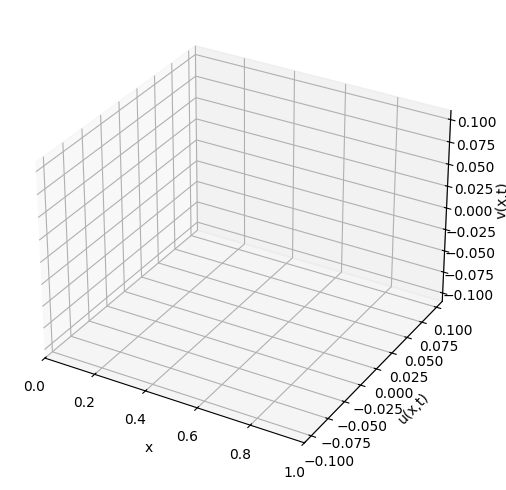

In [41]:
model.eval()
nx_plot = 100
x_plot = np.linspace(0, 1, nx_plot)
nt_frames = 120
t_frames = np.linspace(0, t_max, nt_frames)

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')

line, = ax.plot([], [], [], lw=2)

ax.set_xlim(0, 1)
ax.set_ylim(-1.1*A, 1.1*A)
ax.set_zlim(-1.1*A, 1.1*A)

ax.set_xlabel('x')
ax.set_ylabel('u(x,t)')
ax.set_zlabel('v(x,t)')


 Анимируем и сохраняем результат в `GIF`.

In [42]:
def init():
    line.set_data([], [])
    line.set_3d_properties([])
    return (line,)

def animate(i):
    t_val = t_frames[i]
    x_torch = torch.tensor(x_plot.reshape(-1,1), dtype=torch.float32, device=device)
    t_torch = torch.tensor(np.ones_like(x_plot).reshape(-1,1) * t_val, dtype=torch.float32, device=device)
    with torch.no_grad():
        uv_pred = model(x_torch, t_torch).cpu().numpy()
    u_phys = A * uv_pred[:, 0]
    v_phys = A * uv_pred[:, 1]
    line.set_data(x_plot, u_phys)
    line.set_3d_properties(v_phys)
    ax.set_title(f"t' = {t_val:.3f}")
    return (line,)

anim = animation.FuncAnimation(fig, animate, init_func=init, frames=nt_frames, interval=50, blit=True)
anim.save('wave_3d.gif', writer='pillow', fps=20)
print("Saved wave_3d.gif")

Saved wave_3d.gif
